## Clasificación TF-IDF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
from gensim.utils import simple_preprocess
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

Lo primero que necesitamos es cargar nuestros glosarios de términos para crear nuestro diccionario

In [2]:
def cargar_glosario(categoria):
    fname = f"../Datos/Glosarios/train/glosario_{categoria}.txt"
    glosario = []
    with open(fname, 'r') as f:
        glosario = [termino.rstrip('\n') for termino in f.readlines()]
    return glosario

In [3]:
categorias = ["deportes", "salud", "ciencia", "politica"]
glosarios = {}
for categoria in categorias:
    glosarios[categoria] = cargar_glosario(categoria)

Creamos nuestro diccionario de palabras en base a los terminos del glosario

In [4]:
def create_dictionary(glosarios):
    doc_tokens = [[termino for termino in glosario] for glosario in glosarios.values()]
    dictionary = corpora.Dictionary(doc_tokens)
    return dictionary

In [5]:
glosarios_dict = create_dictionary(glosarios)
print(glosarios_dict)

Dictionary<200 unique tokens: ['aerodinamico', 'atletico', 'booker', 'boston', 'cambio']...>


Cargamos nuestras noticias de test y las convertimos a un bag of words utilizando nuestro diccionario

In [6]:
noticias_test_dataframe = pd.read_csv("../Datos/noticias_test.csv")

In [7]:
def create_bag_of_words(docs_list, dictionary):
    doc_tokens = [simple_preprocess(corpus) for corpus in docs_list]
    docs_bow = [dictionary.doc2bow(doc) for doc in doc_tokens]
    return docs_bow

In [8]:
def create_tfidf(docs_bow):
    docs_tfidf = models.TfidfModel(docs_bow, smartirs="lfc")
    return docs_tfidf

Ahora es momento de crear una bag of words para cada noticia en base a nuestro diccionario

In [9]:
docs_bow = create_bag_of_words(noticias_test_dataframe["corpus"].values, glosarios_dict)
print(docs_bow[19])

[(7, 1), (17, 2), (38, 1), (70, 1)]


Y con el bag of words podemos crear nuestro modelo tfidf

In [10]:
tfidf_model = create_tfidf(docs_bow)
tfidf_model[docs_bow[0]]

[(1, 0.5047168663250167), (27, 0.8632849383877002)]

Representamos nuestros glosarios en tfidf

In [11]:
deportes_bow = glosarios_dict.doc2bow(glosarios["deportes"])
deportes_tfidf = tfidf_model[deportes_bow]

salud_bow = glosarios_dict.doc2bow(glosarios["salud"])
salud_tfidf = tfidf_model[salud_bow]

ciencia_bow = glosarios_dict.doc2bow(glosarios["ciencia"])
ciencia_tfidf = tfidf_model[ciencia_bow]

politica_bow = glosarios_dict.doc2bow(glosarios["politica"])
politica_tfidf = tfidf_model[politica_bow]

Ahora clasificamos

In [12]:
index = similarities.MatrixSimilarity(tfidf_model[docs_bow])
similarities_deportes = index[deportes_tfidf]
similarities_salud = index[salud_tfidf]
similarities_ciencia = index[ciencia_tfidf]
similarities_politica = index[politica_tfidf]

In [13]:
def get_prediction(index, 
                   similarities_deportes,       
                   similarities_salud,                       
                   similarities_ciencia,
                   similarities_politica):
    mejor_match = 0
    mejor = "No clasificado"
    if (similarities_deportes[index] > mejor_match):
        mejor_match = similarities_deportes[index]
        mejor = "sports"
    if (similarities_salud[index] > mejor_match):
        mejor_match = similarities_salud[index]
        mejor = "health"
    if (similarities_ciencia[index] > mejor_match):
        mejor_match = similarities_ciencia[index]
        mejor = "science"
    if (similarities_politica[index] > mejor_match):
        mejor_match = similarities_politica[index]
        mejor = "politics"
    print(mejor)
    return mejor, mejor_match
    

In [14]:
predictions = []
similarities = []
for i in range(len(docs_bow)):
    pred, sim = get_prediction(i, 
                          similarities_deportes,
                          similarities_salud,
                          similarities_ciencia,
                          similarities_politica)
    similarities.append(sim)
    predictions.append(pred)

sports
sports
sports
politics
No clasificado
sports
sports
sports
sports
politics
No clasificado
science
politics
sports
sports
sports
No clasificado
No clasificado
sports
sports
sports
No clasificado
sports
sports
sports
sports
sports
sports
sports
sports
health
sports
science
health
health
sports
health
No clasificado
sports
politics
health
sports
health
health
health
health
science
health
health
sports
health
health
sports
sports
sports
health
science
health
No clasificado
science
health
politics
politics
science
science
sports
sports
science
science
sports
science
science
science
health
politics
health
science
science
health
politics
science
science
health
science
science
politics
health
science
health
science
No clasificado
sports
politics
politics
politics
science
politics
politics
politics
politics
politics
politics
politics
science
politics
politics
politics
politics
health
sports
politics
politics
sports
politics
politics
politics
politics
politics
No clasificado
health


In [15]:
noticias_test_dataframe.insert(2, "preds", predictions)
noticias_test_dataframe.insert(3, "similarity", similarities)

In [16]:
noticias_test_dataframe.to_csv('../Prediccion/predicciones_noticias.csv')

In [17]:
def draw_confusion_matrix(cm, categories, normalize=True):
    # Draw confusion matrix
    fig = plt.figure(figsize=[3*pow(len(categories), 0.5), 2*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    if normalize:
        cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=categories, yticklabels=categories, ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(12-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

In [18]:
def discretizar_categorias(lista_cat):
    lista = []
    for c in lista_cat:
        disc = 0
        if (c=="sports"):
            disc = 1
        elif (c=="health"):
            disc = 2
        elif (c=="science"):
            disc = 3
        elif (c=="politics"):
            disc = 4
        lista.append(disc)
    return np.array(lista)

Accuracy: 64.86486486486487 %
Recall: 65.64285714285714 %
Precision: 65.17045454545453 %
F1 score: 64.44960212201592 %


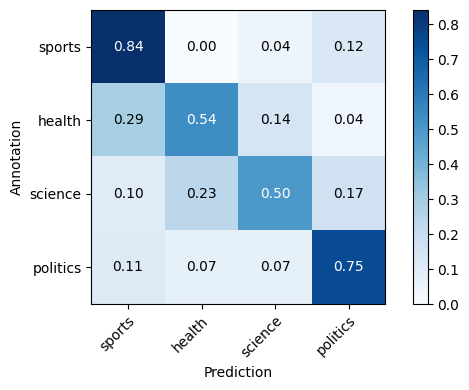

[[21  0  1  3]
 [ 8 15  4  1]
 [ 3  7 15  5]
 [ 3  2  2 21]]


In [19]:
noticias_res = noticias_test_dataframe.copy()    
noticias_test_dataframe = noticias_test_dataframe[noticias_test_dataframe["preds"]!="No clasificado"]
disc_truth = discretizar_categorias(noticias_test_dataframe["category"].values)
disc_pred = discretizar_categorias(noticias_test_dataframe["preds"].values)
print("Accuracy:", accuracy_score(disc_truth, disc_pred)*100, "%")
print("Recall:", recall_score(disc_truth, disc_pred, average='macro')*100, "%")
print("Precision:", precision_score(disc_truth, disc_pred, average='macro')*100, "%")
print("F1 score:", f1_score(disc_truth, disc_pred, average='macro')*100, "%")
cm = confusion_matrix(disc_truth, 
                      disc_pred)
draw_confusion_matrix(cm, ["sports", "health", "science", "politics"])
print(cm)

In [23]:
noticias_res = noticias_res.sort_values('similarity', ascending=False)
categorias = ["sports", "health", "science", "politics", "No clasificado"]
nextline = "\\\ \hline"
for c in categorias:
    print()
    print("            \\begin{table}[!h]")
    print("             \centering")
    print("                \\begin{tabular}{|l|c|c|c|}")
    cat_df = noticias_res[noticias_res["preds"]==c]
    for index, row in cat_df.iterrows():
        print("                        " + row["title"][0: 25] + "... & " + row["preds"] + " & " + row["category"] + " & " + str(round(row["similarity"],3)) + nextline)
    print("                 \end{tabular}")
    print("              \end{table}")


            \begin{table}[!h]
             \centering
                \begin{tabular}{|l|c|c|c|}
                        Golden State asesta otro ... & sports & sports & 0.356\\ \hline
                        Gobert toca fondo - AS ... & sports & sports & 0.355\\ \hline
                        El fútbol es un cuento - ... & sports & sports & 0.325\\ \hline
                        El fútbol fue lo de menos... & sports & sports & 0.305\\ \hline
                        De jefe de estrategia de ... & sports & sports & 0.273\\ \hline
                        Ferrari se enreda otra ve... & sports & sports & 0.272\\ \hline
                        LeBron James: "No necesit... & sports & sports & 0.272\\ \hline
                        Bolaños asegura que los b... & sports & politics & 0.232\\ \hline
                        Domenicali: “Fernando Alo... & sports & sports & 0.219\\ \hline
                        Djokovic, espectador de l... & sports & sports & 0.219\\ \hline
                      